In [12]:
# importing the required modules

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from tqdm import tqdm

In [13]:
2 ** 15

32768

In [51]:
# info about the data
f = 3.3 # initial frequency
N_per_cycle = 512
freq_sampling =  4 * f * N_per_cycle # sampling frequency
noise_add = False
triggering = False
right_clip = True

triggering_mode = 'rising' # rising or falling
N_sample = 2 ** 14 # number of samples
Total_time = N_sample / freq_sampling # total time

time_vary = True

dc_signal = 0.0 # dc signal

# manually setting the amplitude and phase/
amplitude = 0.1
phase = np.pi/4
tolerance = np.deg2rad(3)
print('Tolerance:', np.rad2deg(tolerance))
phis = []

t = np.linspace(0, Total_time, N_sample, endpoint=False) # time array

# creating a sin wave with the frequency array
y = amplitude * np.sin(2 * np.pi * f * t + phase) + dc_signal

# adding some noise to the signal
if noise_add:
    y = y + 0.001 * np.random.normal(size=t.size)

# creeating a squarae wave with the frequency array and a phase shift of 90 degrees
y_square = np.sin(2 * np.pi * f * t)

# converting the signal to a square wave
y_square = np.sign(y_square)

# adding some noise to the signal
if noise_add:
    y_square = y_square + 0.0009 * np.random.normal(size=t.size)

if time_vary:
    t_cycle = 1/f
    N_cycle = N_sample * (t_cycle / Total_time)
    rand_idx = np.random.randint(0, int(N_cycle))

    N_sample2 = N_sample - (2 * rand_idx)

    t = t[rand_idx: N_sample2 + rand_idx]
    y = y[rand_idx: N_sample2 + rand_idx]
    y_square = y_square[rand_idx: N_sample2 + rand_idx]



if triggering:
    # centralizing the reference signal
    y_square_max = np.max(y_square)
    y_square_min = np.min(y_square)
    y_square = y_square - ((y_square_max + y_square_min)/2)

    if triggering_mode == 'rising':
        first_rise_idx = 0
        for i in range(1, N_sample):
            if y_square[i] > 0 and y_square[i-1] < 0:
                first_rise_idx = i
                break
    if triggering_mode == 'falling':
        first_rise_idx = 0
        for i in range(1, N_sample):
            if y_square[i] < 0 and y_square[i-1] > 0:
                first_rise_idx = i
                break
    # triggered signal, reference signal and time
    triggered_sig = y[first_rise_idx:]
    triggered_ref = y_square[first_rise_idx:]
    triggered_time = t[first_rise_idx:] - t[first_rise_idx] # time starts from zero
else:
    triggered_sig = y
    triggered_ref = y_square
    triggered_time = t


if right_clip:
    
    # finding the first fall from the right end of the signal
    last_fall_idx = 0
    for i in range(len(triggered_ref)-1, 0, -1):
        if triggered_ref[i] > 0 and triggered_ref[i-1] < 0:
            last_fall_idx = i
            break
    print('last indx of ref:', len(triggered_ref) - 1)
    print('last fall index:', last_fall_idx)

    print('last time of ref:', triggered_time[-1])
    print('last fall time:', triggered_time[last_fall_idx])

    # triggered signal, reference signal and time
    triggered_sig = triggered_sig[:last_fall_idx]
    triggered_ref = triggered_ref[:last_fall_idx]
    triggered_time = triggered_time[:last_fall_idx]



Tolerance: 3.0000000000000004
last indx of ref: 12495
last fall index: 12393
last time of ref: 2.1364524147727275
last fall time: 2.121360085227273


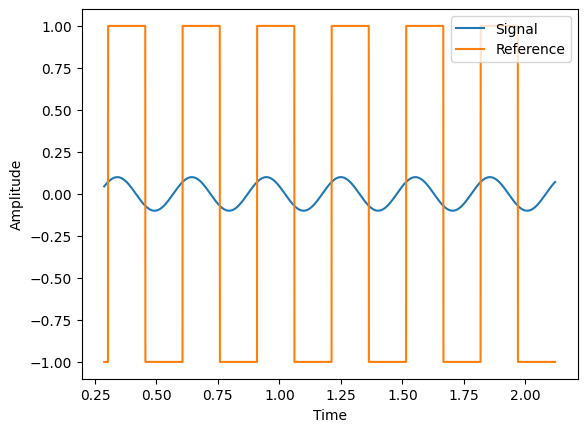

In [52]:
# plotting the signal and the reference signal
plt.plot(triggered_time, triggered_sig, label='Signal')
plt.plot(triggered_time, triggered_ref, label='Reference')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()



In [53]:
# building corresponding quadrature reference signal
y_square_quad = np.cos(2 * np.pi * f * triggered_time)
y_square_quad = np.sign(y_square_quad)[:len(triggered_ref)]


In [54]:
# multiplying the signal with the reference signals
y_in_phase = triggered_sig * triggered_ref
y_quad = triggered_sig * y_square_quad

In [55]:
# performing the operations
sum_y_inphase = np.sum(y_in_phase) / len(y_in_phase)
sum_y_quad = np.sum(y_quad) / len(y_quad)

h = np.pi / (4 * N_per_cycle * np.sin(np.pi / (4 * N_per_cycle)))
h = 1

In [56]:
# Observed amplitude and phase
A = np.sqrt(sum_y_inphase ** 2 + sum_y_quad ** 2) *( np.pi / 2) * (1 / h)

phase = np.arctan2(sum_y_quad, sum_y_inphase) + (np.pi / (4 * N_per_cycle))

print('Observed Amplitude:', A)
print(f'Observed Phase: {np.rad2deg(phase)} deg')


Observed Amplitude: 0.09910833435383137
Observed Phase: 45.73720135376048 deg
